Simple RNN (many-to-one 문제)
 - 사인파형 시계열을 입력으로 받아 다음 스텝의 출력을 예측
 - 3개의 순서열을 입력한 후 출력값이 target과 일치하게 만든다

- 스킵

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
seed= 2022
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
text = '''경마장에 있는 말이 뛰고 있다.
그의 말이 법이다.
가는 말이 고와야 오는 말이 곱다.'''

- 텍스트 전처리

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [8]:
# 단어 집합 생성
t = Tokenizer()
t.fit_on_texts([text])

In [11]:
# 특징
# 1. 가나다 순서가 아니라 많이 나온 순서
# 2. 1에서 부터 시작함
t.word_index

{'가는': 8,
 '경마장에': 2,
 '고와야': 9,
 '곱다': 11,
 '그의': 6,
 '뛰고': 4,
 '말이': 1,
 '법이다': 7,
 '오는': 10,
 '있는': 3,
 '있다': 5}

In [12]:
# 단어 집합 크기 -keras Tokenizer의 시작 인덱스가 1이기 때문에 1을 더해줘야 함
vocab_size = len(t.word_index) + 1
vocab_size

12

In [13]:
t.texts_to_sequences(['그의 말이 법이다'])

[[6, 1, 7]]

In [14]:
# corpus를 encoding 한 결과
for line in text.split('\n'):
    encoded = t.texts_to_sequences([line])[0]
    print(encoded)

[2, 3, 1, 4, 5]
[6, 1, 7]
[8, 1, 9, 10, 1, 11]


In [15]:
t.texts_to_sequences([text])

[[2, 3, 1, 4, 5, 6, 1, 7, 8, 1, 9, 10, 1, 11]]

In [20]:
sequences = []
for line in text.split('\n'):
    encoded = t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequences.append(encoded[:i+1])
sequences

[[2, 3],
 [2, 3, 1],
 [2, 3, 1, 4],
 [2, 3, 1, 4, 5],
 [6, 1],
 [6, 1, 7],
 [8, 1],
 [8, 1, 9],
 [8, 1, 9, 10],
 [8, 1, 9, 10, 1],
 [8, 1, 9, 10, 1, 11]]

In [21]:
max_len = max(len(seq) for seq in sequences)
max_len

6

- Padding
 - 전체 샘플 길이를 max_len에 맞추도록 0을 추가
 - 압쪽을 채우는 pre 옵션이 디폴트

In [22]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
sequences[:5]

array([[0, 0, 0, 0, 2, 3],
       [0, 0, 0, 2, 3, 1],
       [0, 0, 2, 3, 1, 4],
       [0, 2, 3, 1, 4, 5],
       [0, 0, 0, 0, 6, 1]], dtype=int32)

In [23]:
X = sequences[:, :-1]
y = sequences[:, -1]
X.shape, y.shape

((11, 5), (11,))

In [25]:
Y = to_categorical(y)
Y.shape

(11, 12)

- 모델 
 - Embedding
 - SimpleRNN
 - Dese

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

In [28]:
# Embedding=4, SimpleRNN=32
# Embedding vector의 갯수가 RNN layer에서 feature개수
model1 = Sequential([
    Embedding(vocab_size, 4, input_length = max_len-1),
    SimpleRNN(32),
    Dense(vocab_size, activation='softmax')
])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 4)              48        
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1184      
                                                                 
 dense (Dense)               (None, 12)                396       
                                                                 
Total params: 1,628
Trainable params: 1,628
Non-trainable params: 0
_________________________________________________________________


In [33]:
model1.compile('adam', 'categorical_crossentropy', ['accuracy'])

In [34]:
hist = model1.fit(X, Y, epochs=200, verbose=0)

In [35]:
hist.history['accuracy'][-1]

1.0

- 모델검증

In [36]:
from google.colab import files

In [37]:
up = files.upload()

Saving my_util.py to my_util.py


In [40]:
from my_util import sentence_generation
sentence_generation(model1, t, max_len, '경마장에', 3)

'경마장에 있는 말이 뛰고'

In [44]:
sentence_generation(model1, t, max_len, '가는', 5)

'가는 말이 고와야 오는 말이 곱다'

### 모델변화
 - Embedding vector 갯수 : [2, 4, 6]
 - RNN 유닛 갯수: [24, 32, 48]

In [47]:
for n_embed in [2, 4, 6]:
    for n_unit in [24, 32, 48]:
        model = Sequential([
            Embedding(vocab_size, n_embed, input_length = max_len - 1),
            SimpleRNN(n_unit),
            Dense(vocab_size, activation='softmax')
        ])
        model.compile('adam', 'categorical_crossentropy', ['accuracy'])
        hist = model.fit(X, Y, epochs=200, verbose=0)
        print('=============================================')
        print(f'Embedding vector: {n_embed}, RNN unit: {n_unit}')
        print(f"정확도: {hist.history['accuracy'][-1]:.4f}")
        print(sentence_generation(model, t, max_len, '경마장에', 4))
        print(sentence_generation(model, t, max_len, '그의', 2))
        print(sentence_generation(model, t, max_len, '가는', 5))
        print()

Embedding vector: 2, RNN unit: 24
정확도: 0.8182
경마장에 말이 말이 오는 말이
그의 말이 법이다
가는 말이 법이다 오는 말이 곱다

Embedding vector: 2, RNN unit: 32
정확도: 0.8182
경마장에 말이 법이다 오는 말이
그의 말이 고와야
가는 말이 고와야 오는 말이 곱다

Embedding vector: 2, RNN unit: 48
정확도: 0.9091
경마장에 말이 고와야 오는 말이
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다

Embedding vector: 4, RNN unit: 24
정확도: 0.8182
경마장에 말이 말이 오는 말이
그의 말이 법이다
가는 말이 법이다 오는 말이 곱다

Embedding vector: 4, RNN unit: 32
정확도: 1.0000
경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다

Embedding vector: 4, RNN unit: 48
정확도: 0.9091
경마장에 말이 고와야 오는 말이
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다

Embedding vector: 6, RNN unit: 24
정확도: 1.0000
경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다

Embedding vector: 6, RNN unit: 32
정확도: 1.0000
경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다

Embedding vector: 6, RNN unit: 48
정확도: 1.0000
경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다



### LSTM을 이용한 텍스트 생성
 - 데이터 다운로드 : 캐글 New York Times Comments

In [1]:
import pandas as pd
from google.colab import files
up = files.upload()

Saving ArticlesApril2018.csv to ArticlesApril2018.csv


In [2]:
df = pd.read_csv('ArticlesApril2018.csv', encoding='latin1')
df.head(3)

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleadersâ Settlement Offer...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"âI understand that they could meet with us, ...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,Whatâs it like to eat at the second incarnat...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...


- 데이터 전처리 : headline columns 만 사용

In [3]:
 df.headline.isna().sum()

0

In [4]:
headlines = df.headline.values.tolist()

In [5]:
headlines[:5]

['Former N.F.L. Cheerleadersâ\x80\x99 Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

In [6]:
len(headlines)

1324

In [7]:
headlines = [line for line in df.headline.values if line != 'Unknown']
len(headlines)

1214

In [8]:
# encoding, 구둣점 제거, 소문자 변환
import re
def preprocessing(s):
    s = s.encode('utf8').decode('ascii', 'ignore')
    s = re.sub('[^A-Za-z0-9 ]', '', s)
    return s.lower()

In [9]:
headlines = [preprocessing(line) for line in headlines]
headlines[:5] 

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [11]:
t = Tokenizer()
t.fit_on_texts(headlines)

In [12]:
vocab_size = len(t.word_index) + 1
vocab_size

3494

In [13]:
sequences = []
for line in headlines :
    encoded = t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequences.append(encoded[: i+1])
sequences[:10]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116]]

In [14]:
max_len = max(len(seq) for seq in sequences)
max_len

24

In [15]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
sequences[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          99,  269],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   99,
         269,  371],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   99,  269,
         371, 1115],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   99,  269,  371,
        1115,  582],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   99,  269,  371, 1115,
         582,   52],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   99,  269,  371, 1115,  582,
       

In [16]:
X = sequences[:, :-1]
Y = sequences[:, -1]
Y = to_categorical(Y)
X.shape, Y.shape

((7803, 23), (7803, 3494))

- 모델 정의/설정/학습
 - Embedding vector 갯수 : 10
 - LSTM unit 갯수 : 128

In [17]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding

In [18]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [23]:
model1 = Sequential([
    Embedding(vocab_size, 10, input_length = max_len - 1),
    LSTM(128),
    Dense(vocab_size, activation='softmax')
    
])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 10)            34940     
                                                                 
 lstm_1 (LSTM)               (None, 128)               71168     
                                                                 
 dense_1 (Dense)             (None, 3494)              450726    
                                                                 
Total params: 556,834
Trainable params: 556,834
Non-trainable params: 0
_________________________________________________________________


In [24]:
model1.compile('adam', 'categorical_crossentropy', ['accuracy'])

In [25]:
hist1 = model1.fit(X, Y, epochs=200, verbose=1)

Epoch 1/200
244/244 [==============================] - 3s 6ms/step - loss: 7.6258 - accuracy: 0.0296
Epoch 2/200
244/244 [==============================] - 1s 6ms/step - loss: 7.1109 - accuracy: 0.0278
Epoch 3/200
244/244 [==============================] - 1s 6ms/step - loss: 6.9727 - accuracy: 0.0352
Epoch 4/200
244/244 [==============================] - 1s 6ms/step - loss: 6.8415 - accuracy: 0.0417
Epoch 5/200
244/244 [==============================] - 1s 6ms/step - loss: 6.6838 - accuracy: 0.0442
Epoch 6/200
244/244 [==============================] - 1s 6ms/step - loss: 6.4977 - accuracy: 0.0483
Epoch 7/200
244/244 [==============================] - 1s 6ms/step - loss: 6.2905 - accuracy: 0.0529
Epoch 8/200
244/244 [==============================] - 1s 6ms/step - loss: 6.0752 - accuracy: 0.0583
Epoch 9/200
244/244 [==============================] - 1s 6ms/step - loss: 5.8641 - accuracy: 0.0620
Epoch 10/200
244/244 [==============================] - 1s 6ms/step - loss: 5.6684 - accura

In [27]:
hist1.history['accuracy'][-1]

0.9158016443252563

- 모델검증 

In [28]:
up = files.upload()

Saving my_util.py to my_util.py


In [29]:
from my_util import sentence_generation

In [32]:
print(sentence_generation(model1, t, max_len, 'former', 8))
print(sentence_generation(model1, t, max_len, 'epa', 8))
print(sentence_generation(model1, t, max_len, 'how', 8))

former cheney aide is pardoned by trump in cia
epa to unveil a new rule its effect less
how to make facebook more accountable to live in


In [33]:
y_acc = hist1.history['accuracy']
y_loss = hist1.history['loss']
xs = np.arange(1, len(y_acc)+1)

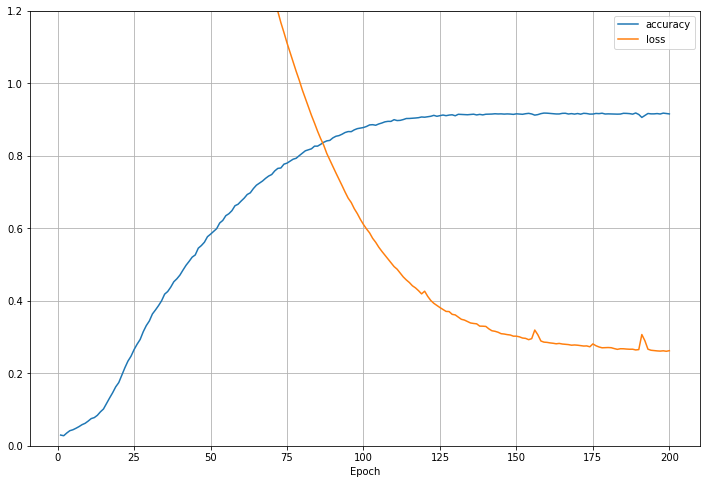

In [34]:

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='accuracy')
plt.plot(xs, y_loss, label='loss')
plt.legend(), plt.grid()
plt.ylim(0,1.2), plt.xlabel('Epoch')
plt.show()

### SimpleRNN으로 했을 때


In [17]:
from tensorflow.keras.layers import SimpleRNN

In [18]:
model2 = Sequential([
    Embedding(vocab_size, 10, input_length = max_len -1),
    SimpleRNN(128),
    Dense(vocab_size, activation='softmax')
])
model2.summary()

NameError: ignored

In [19]:
model2.compile('adam', 'categorical_crossentropy', ['accuracy'])

NameError: ignored

In [20]:
hist2 = model2.fit(X, Y, epochs=200, verbose=0)

NameError: ignored

In [43]:
hist2.history['accuracy'][-1]

0.9145200848579407

### GRU
 - Embedding vector 갯수 : 10
 - GRU unit 갯수 : 128

In [21]:

import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [22]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, Embedding

In [23]:
model1 = Sequential([
    Embedding(vocab_size, 10, input_length=max_len -1),
    GRU(128),
    Dense(vocab_size, activation='softmax')
])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 10)            34940     
                                                                 
 gru (GRU)                   (None, 128)               53760     
                                                                 
 dense (Dense)               (None, 3494)              450726    
                                                                 
Total params: 539,426
Trainable params: 539,426
Non-trainable params: 0
_________________________________________________________________


In [24]:
model1.compile('adam', 'categorical_crossentropy', ['accuracy'])

In [26]:
hist1 = model1.fit(X, Y, epochs=200, verbose=1)

Epoch 1/200
244/244 [==============================] - 2s 10ms/step - loss: 7.6793 - accuracy: 0.0302
Epoch 2/200
244/244 [==============================] - 2s 7ms/step - loss: 7.1224 - accuracy: 0.0308
Epoch 3/200
244/244 [==============================] - 2s 6ms/step - loss: 6.9090 - accuracy: 0.0442
Epoch 4/200
244/244 [==============================] - 2s 7ms/step - loss: 6.6893 - accuracy: 0.0481
Epoch 5/200
244/244 [==============================] - 2s 6ms/step - loss: 6.4516 - accuracy: 0.0536
Epoch 6/200
244/244 [==============================] - 2s 8ms/step - loss: 6.1916 - accuracy: 0.0583
Epoch 7/200
244/244 [==============================] - 1s 6ms/step - loss: 5.9183 - accuracy: 0.0619
Epoch 8/200
244/244 [==============================] - 1s 6ms/step - loss: 5.6428 - accuracy: 0.0686
Epoch 9/200
244/244 [==============================] - 1s 6ms/step - loss: 5.3802 - accuracy: 0.0741
Epoch 10/200
244/244 [==============================] - 1s 6ms/step - loss: 5.1275 - accur

In [27]:
hist1.history['accuracy'][-1]

0.9152889847755432

In [28]:
up = files.upload()

Saving my_util.py to my_util.py


In [29]:
from my_util import sentence_generation

In [30]:
print(sentence_generation(model1, t, max_len, 'former', 8))
print(sentence_generation(model1, t, max_len, 'epa', 8))
print(sentence_generation(model1, t, max_len, 'how', 8))

former judge to review files seized in searches battle
epa to unveil a new rule its effect less
how to make facebook more accountable risks as it


In [31]:
y_acc = hist1.history['accuracy']
y_loss = hist1.history['loss']
xs = np.arange(1, len(y_acc)+1)

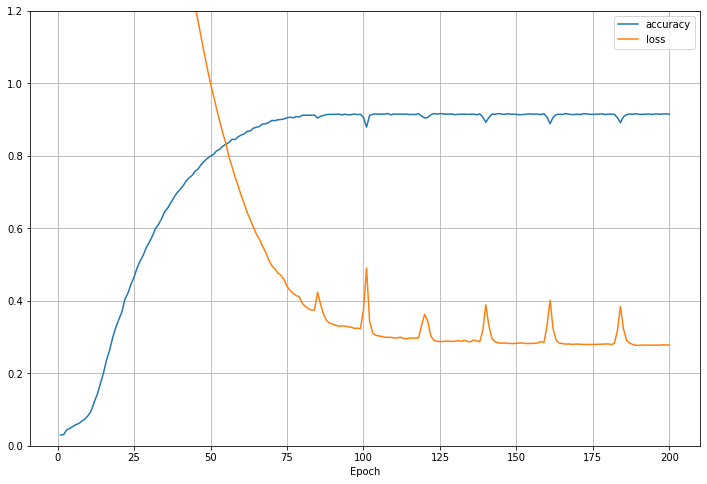

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='accuracy')
plt.plot(xs, y_loss, label='loss')
plt.legend(), plt.grid()
plt.ylim(0,1.2), plt.xlabel('Epoch')
plt.show()

### SimpleRNN을 이용한 SMS Spam 분류
 - 캐글 데이터: https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [63]:
import pandas as pd
url = 'https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv'

In [64]:
df = pd.read_csv(url, encoding='latin1')
df.head(3) 

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [65]:
# Selection
df = df[['v1', 'v2']]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [66]:
# Null data check
df.isna().sum().sum()

0

In [67]:
df.v1.shape, df.v2.shape

((5572,), (5572,))

In [68]:
df.drop_duplicates(subset=['v2'], inplace=True)
df.shape

(5169, 2)

In [69]:
# ['ham', 'spam'] -> [0, 1]
df.v1 = df.v1.replace(['ham', 'spam'], [0,1])
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [70]:
# ham/spam 분포
df.v1.value_counts()

0    4516
1     653
Name: v1, dtype: int64

- 전처리

In [71]:
x, y = df.v2.values, df.v1.values
x.shape, y.shape

((5169,), (5169,))

In [82]:
import re
def preprocessing(s):
    s = s.encode('utf8').decode('ascii', 'ignore')
    s = re.sub('[^a-zA-Z0-9 ]', '', s)
    return s.lower()

In [83]:
X_data = [ preprocessing(sent) for sent in x]

In [86]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [87]:
t = Tokenizer()
t.fit_on_texts(X_data)

In [88]:
vocab_size = len(t.index_word) + 1
vocab_size

9479

In [89]:
sequences = t.texts_to_sequences(X_data)
print(sequences[2])

[54, 508, 8, 22, 4, 959, 960, 2, 217, 2566, 1291, 664, 2567, 2568, 268, 2569, 71, 2566, 2, 2570, 2, 336, 508, 3839, 84, 3840, 424, 3841]


In [90]:
max_len = max(len(seq) for seq in sequences)
max_len

171

In [93]:
data = pad_sequences(sequences, maxlen=max_len, padding='pre')

- train/test 분리

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, y, stratify=y, test_size=0.2,
    random_state=2022
)

In [96]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape 

((4135, 171), (1034, 171), (4135,), (1034,))

### 모델 정의/설정/학습

In [98]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [99]:
model1 = Sequential([
    Embedding(vocab_size, 32, input_length=max_len),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 171, 32)           303328    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 305,441
Trainable params: 305,441
Non-trainable params: 0
_________________________________________________________________


In [100]:
model_path = 'best-spam-RNN.h5' 
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=10)

In [104]:
model1.compile('adam', 'binary_crossentropy', ['accuracy'])

In [106]:
hist1 = model1.fit(X_train, y_train, validation_split=0.2,
           epochs=100, batch_size=64, verbose=1,
           callbacks=[mc, es])

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 0.3504 - accuracy: 0.8779
Epoch 1: val_loss improved from inf to 0.20598, saving model to best-spam-RNN.h5
52/52 [==============================] - 6s 105ms/step - loss: 0.3504 - accuracy: 0.8779 - val_loss: 0.2060 - val_accuracy: 0.9480
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9722
Epoch 2: val_loss improved from 0.20598 to 0.10040, saving model to best-spam-RNN.h5
52/52 [==============================] - 5s 95ms/step - loss: 0.1140 - accuracy: 0.9722 - val_loss: 0.1004 - val_accuracy: 0.9746
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9912
Epoch 3: val_loss improved from 0.10040 to 0.09193, saving model to best-spam-RNN.h5
52/52 [==============================] - 5s 90ms/step - loss: 0.0477 - accuracy: 0.9912 - val_loss: 0.0919 - val_accuracy: 0.9758
Epoch 4/100
51/52 [============================>.] - ETA: 0s - loss: 0.02

In [107]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

33/33 [==============================] - 1s 11ms/step - loss: 0.0827 - accuracy: 0.9768


[0.08272530883550644, 0.9767891764640808]

In [109]:
y_acc = hist1.history['accuracy']
y_vloss = hist1.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

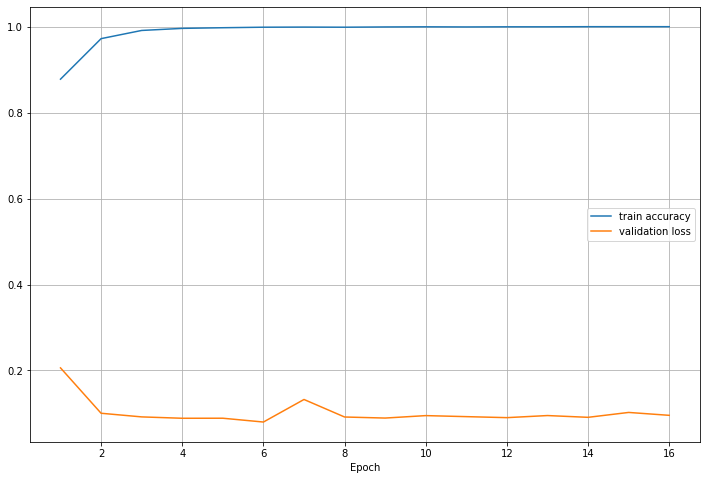

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend(), plt.grid()
plt.xlabel('Epoch')
plt.show()

### 로이터 뉴스 분류하기 - LSTM

In [2]:
import  numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

In [112]:
(X_train, y_train), (X_test, y_test) = reuters.load_data()

2121728/2110848 [==============================] - 0s 0us/step


In [113]:
len(X_train), len(X_test)

(8982, 2246)

In [114]:
vocab_size = max(y_train) + 1
vocab_size

46

In [115]:
print(X_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [116]:
type(reuters.get_word_index())

565248/550378 [==============================] - 0s 0us/step


dict

In [121]:
reuters.get_word_index()

{'mdbl': 10996,
 'fawc': 16260,
 'degussa': 12089,
 'woods': 8803,
 'hanging': 13796,
 'localized': 20672,
 'sation': 20673,
 'chanthaburi': 20675,
 'refunding': 10997,
 'hermann': 8804,
 'passsengers': 20676,
 'stipulate': 20677,
 'heublein': 8352,
 'screaming': 20713,
 'tcby': 16261,
 'four': 185,
 'grains': 1642,
 'broiler': 20680,
 'wooden': 12090,
 'wednesday': 1220,
 'highveld': 13797,
 'duffour': 7593,
 '0053': 20681,
 'elections': 3914,
 '270': 2563,
 '271': 3551,
 '272': 5113,
 '273': 3552,
 '274': 3400,
 'rudman': 7975,
 '276': 3401,
 '277': 3478,
 '278': 3632,
 '279': 4309,
 'dormancy': 9381,
 'errors': 7247,
 'deferred': 3086,
 'sptnd': 20683,
 'cooking': 8805,
 'stratabit': 20684,
 'designing': 16262,
 'metalurgicos': 20685,
 'databank': 13798,
 '300er': 20686,
 'shocks': 20687,
 'nawg': 7972,
 'tnta': 20688,
 'perforations': 20689,
 'affiliates': 2891,
 '27p': 20690,
 'ching': 16263,
 'china': 595,
 'wagyu': 16264,
 'affiliated': 3189,
 'chino': 16265,
 'chinh': 16266,
 '

In [122]:
index_word = {}
for key, value in reuters.get_word_index().items():
    index_word[value] = key
len(index_word)

30979

In [124]:
len(reuters.get_word_index()), len(index_word)

(30979, 30979)

In [125]:
# 첫번째 기사 복원
' '.join(index_word[index] for index in X_train[0])

'the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs'

In [129]:
# 뉴스 기사의 최대/평균 길이
max(len(s) for s in X_train), sum(map(len, X_train)) / len(X_train)

(2376, 145.5398574927633)

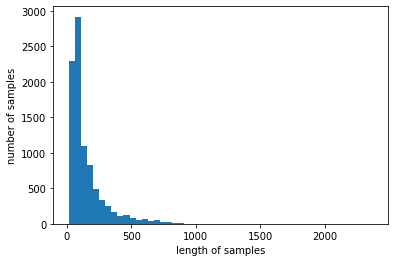

In [130]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

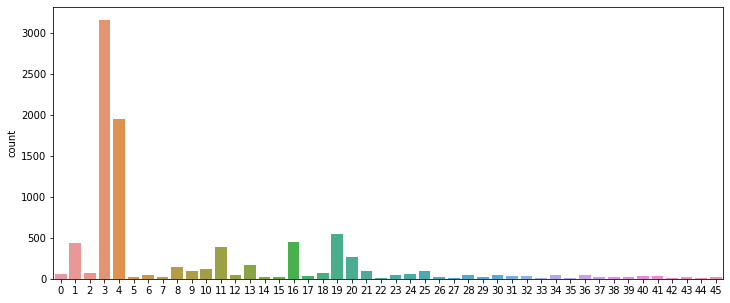

In [131]:

# 뉴스 그룹의 분포
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,5))
sns.countplot(y_train);

### LSTM으로 로이터 뉴스 분류
 - 문장길이 : 100단어 까지 (최대: 2,376)
 - 단어: 빈도수 기준 1,000 단어 (총단어수:30,979)

In [1]:
max_words = 1000
max_len = 100

In [3]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(
    num_words=max_words, test_split=0.2
)

2121728/2110848 [==============================] - 0s 0us/step


In [4]:
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [6]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8982, 100), (2246, 100), (8982, 46), (2246, 46))

In [7]:
model1 = Sequential([
    Embedding(max_words, 64, input_length=max_len),
    LSTM(100),
    Dense(46, activation='softmax')
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           64000     
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 46)                4646      
                                                                 
Total params: 134,646
Trainable params: 134,646
Non-trainable params: 0
_________________________________________________________________


In [8]:
model_path = 'best-reuters-lstm.h5'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=10)

In [9]:
model1.compile('adam', 'categorical_crossentropy', ['accuracy'])

In [10]:
hist1 = model1.fit(X_train, Y_train, validation_split=0.2,
                   epochs=100, batch_size=128, callbacks=[mc,es])

Epoch 1/100
54/57 [===========================>..] - ETA: 0s - loss: 2.7293 - accuracy: 0.3299
Epoch 1: val_loss improved from inf to 2.40400, saving model to best-reuters-lstm.h5
57/57 [==============================] - 9s 26ms/step - loss: 2.7159 - accuracy: 0.3317 - val_loss: 2.4040 - val_accuracy: 0.3450
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 2.4047 - accuracy: 0.3534
Epoch 2: val_loss improved from 2.40400 to 2.38775, saving model to best-reuters-lstm.h5
57/57 [==============================] - 1s 18ms/step - loss: 2.4047 - accuracy: 0.3534 - val_loss: 2.3877 - val_accuracy: 0.3450
Epoch 3/100
57/57 [==============================] - ETA: 0s - loss: 2.2811 - accuracy: 0.4244
Epoch 3: val_loss improved from 2.38775 to 2.05271, saving model to best-reuters-lstm.h5
57/57 [==============================] - 1s 13ms/step - loss: 2.2811 - accuracy: 0.4244 - val_loss: 2.0527 - val_accuracy: 0.4758
Epoch 4/100
56/57 [============================>.] - ETA: 0s -

In [14]:
best_model1 = load_model(model_path)
best_model1.evaluate(X_test, Y_test)

71/71 [==============================] - 1s 7ms/step - loss: 1.2785 - accuracy: 0.6839


[1.278498888015747, 0.683882474899292]

In [15]:
y_acc = hist1.history['accuracy']
y_vloss = hist1.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

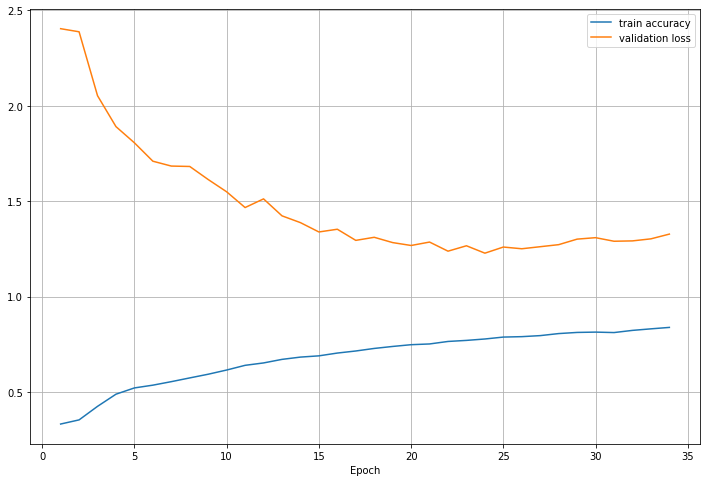

In [16]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend(), plt.grid()
plt.xlabel('Epoch')
plt.show()

####LSTM으로 감성분석
- 단어 빈도수: 10,000 (총 88,584)
- 리뷰 단어수: 500 (최대 2,494)
- 최대 데이터 갯수 ==> 여러분들의 몫
- train: 25000, valid: 10000, test: 15000
- 수업 시간
- train: 20000, test: 5000 (valid: 20%)

In [1]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.datasets import imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

17473536/17464789 [==============================] - 0s 0us/step


((25000,), (25000,), (25000,), (25000,))

In [4]:
from sklearn.model_selection import train_test_split
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, stratify=y_test, test_size=0.6,
    random_state=seed
)
X_valid.shape, X_test.shape, y_valid.shape, y_test.shape

((10000,), (15000,), (10000,), (15000,))

In [5]:
max(len(s) for s in X_train), sum(map(len, X_train)) / len(X_train)

(2494, 238.71364)

In [6]:
vocab_size = len(imdb.get_word_index()) + 1
vocab_size

1654784/1641221 [==============================] - 0s 0us/step


88585

In [7]:
max_len = max(len(s) for s in X_train)

In [8]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)
X_valid = pad_sequences(X_valid, maxlen = max_len)
X_train.shape, X_test.shape, X_valid.shape

((25000, 2494), (15000, 2494), (10000, 2494))

In [12]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, MaxPooling1D, GlobalMaxPooling1D, Conv1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [10]:
model1 = Sequential([
    Embedding(vocab_size, 100, input_length = max_len),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2494, 100)         8858500   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 8,975,877
Trainable params: 8,975,877
Non-trainable params: 0
_________________________________________________________________


In [11]:
model1.compile('adam', 'binary_crossentropy', ['accuracy'])

In [12]:
model_path = 'best-idbm-LSTM.h5'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only = True)
es = EarlyStopping(patience=10)

In [15]:
hist1 = model1.fit(X_train, y_train, validation_data = (X_valid, y_valid),
                  epochs= 50, batch_size= 128,
                  callbacks=[mc, es], verbose=1)

Epoch 1/50
196/196 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.8852
Epoch 1: val_loss improved from inf to 0.35609, saving model to best-idbm-LSTM.h5
196/196 [==============================] - 37s 187ms/step - loss: 0.2819 - accuracy: 0.8852 - val_loss: 0.3561 - val_accuracy: 0.8484
Epoch 2/50
196/196 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.9498
Epoch 2: val_loss did not improve from 0.35609
196/196 [==============================] - 36s 185ms/step - loss: 0.1451 - accuracy: 0.9498 - val_loss: 0.3569 - val_accuracy: 0.8480
Epoch 3/50
196/196 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.9678
Epoch 3: val_loss did not improve from 0.35609
196/196 [==============================] - 35s 179ms/step - loss: 0.0930 - accuracy: 0.9678 - val_loss: 0.4432 - val_accuracy: 0.8613
Epoch 4/50
196/196 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.9869
Epoch 4: val_loss did not improve from

In [16]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

469/469 [==============================] - 20s 42ms/step - loss: 0.3598 - accuracy: 0.8458


[0.3598017990589142, 0.84579998254776]

- Case 1) Conv1D x 2

In [13]:
model2 = Sequential([ 
    Embedding(vocab_size, 100, input_length=max_len),
    Dropout(0.5),
    Conv1D(64, 7, activation='relu'),
    MaxPooling1D(7),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(5),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2494, 100)         8858500   
                                                                 
 dropout_1 (Dropout)         (None, 2494, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, 2488, 64)          44864     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 355, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 351, 64)           20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 70, 64)           0         
 1D)                                                    

In [14]:
model2.compile('adam', 'binary_crossentropy', ['accuracy'])
model2_path = 'best-imdb-conv1d-conv1d.h5'
mc1 = ModelCheckpoint(model2_path, verbose=1, save_best_only=True)
es1 = EarlyStopping(patience=5)

In [16]:
hist2 = model2.fit(
    X_train, y_train, validation_data=(X_valid, y_valid),
    epochs=30, batch_size=64, callbacks=[mc1,es1]
)

Epoch 1/30
391/391 [==============================] - ETA: 0s - loss: 0.4820 - accuracy: 0.7331
Epoch 1: val_loss improved from inf to 0.31870, saving model to best-imdb-conv1d-conv1d.h5
391/391 [==============================] - 33s 40ms/step - loss: 0.4820 - accuracy: 0.7331 - val_loss: 0.3187 - val_accuracy: 0.8651
Epoch 2/30
391/391 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.9136
Epoch 2: val_loss did not improve from 0.31870
391/391 [==============================] - 15s 40ms/step - loss: 0.2233 - accuracy: 0.9136 - val_loss: 0.3313 - val_accuracy: 0.8590
Epoch 3/30
391/391 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.9556
Epoch 3: val_loss did not improve from 0.31870
391/391 [==============================] - 15s 37ms/step - loss: 0.1224 - accuracy: 0.9556 - val_loss: 0.3787 - val_accuracy: 0.8502
Epoch 4/30
391/391 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9814
Epoch 4: val_loss did not improv

In [17]:
best_model2 = load_model(model2_path)
best_model2.evaluate(X_test, y_test)

469/469 [==============================] - 3s 6ms/step - loss: 0.3247 - accuracy: 0.8586


[0.32465168833732605, 0.8586000204086304]

- Case 2) Conv1D + LSTM

In [19]:
model3 = Sequential([ 
    Embedding(vocab_size, 100, input_length=max_len),
    Dropout(0.5),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(5),
    LSTM(100),
    Dense(1, activation='sigmoid')
])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2494, 100)         8858500   
                                                                 
 dropout_2 (Dropout)         (None, 2494, 100)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, 2490, 64)          32064     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 498, 64)          0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                      

In [20]:
model3.compile('adam', 'binary_crossentropy', ['accuracy'])
model3_path = 'best-imdb-conv1d-lstm.h5'
mc3 = ModelCheckpoint(model3_path, verbose=1, save_best_only=True)
es3 = EarlyStopping(patience=5)

In [23]:
hist3 = model3.fit(
    X_train, y_train, validation_data=(X_valid, y_valid),
    epochs=30, batch_size=64, callbacks=[mc3,es3]
)

Epoch 1/30
391/391 [==============================] - ETA: 0s - loss: 0.3859 - accuracy: 0.8123
Epoch 1: val_loss improved from inf to 0.28532, saving model to best-imdb-conv1d-lstm.h5
391/391 [==============================] - 27s 60ms/step - loss: 0.3859 - accuracy: 0.8123 - val_loss: 0.2853 - val_accuracy: 0.8847
Epoch 2/30
390/391 [============================>.] - ETA: 0s - loss: 0.1595 - accuracy: 0.9419
Epoch 2: val_loss did not improve from 0.28532
391/391 [==============================] - 23s 59ms/step - loss: 0.1594 - accuracy: 0.9420 - val_loss: 0.3147 - val_accuracy: 0.8716
Epoch 3/30
390/391 [============================>.] - ETA: 0s - loss: 0.0802 - accuracy: 0.9734
Epoch 3: val_loss did not improve from 0.28532
391/391 [==============================] - 23s 58ms/step - loss: 0.0801 - accuracy: 0.9734 - val_loss: 0.3749 - val_accuracy: 0.8727
Epoch 4/30
390/391 [============================>.] - ETA: 0s - loss: 0.0384 - accuracy: 0.9880
Epoch 4: val_loss did not improve 

In [24]:
best_model3 = load_model(model3_path)
best_model3.evaluate(X_test, y_test)

469/469 [==============================] - 6s 12ms/step - loss: 0.2832 - accuracy: 0.8853


[0.2831706702709198, 0.8853333592414856]

- Case 3) Conv1D + Dense

In [25]:
model4 = Sequential([ 
    Embedding(vocab_size, 100, input_length=max_len),
    Dropout(0.5),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(5),
    GlobalMaxPooling1D(),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 2494, 100)         8858500   
                                                                 
 dropout_3 (Dropout)         (None, 2494, 100)         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 2490, 64)          32064     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 498, 64)          0         
 1D)                                                             
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 100)              

In [26]:
model4.compile('adam', 'binary_crossentropy', ['accuracy'])
model4_path = 'best-imdb-conv1d-dense.h5'
mc3 = ModelCheckpoint(model4_path, verbose=1, save_best_only=True)
es3 = EarlyStopping(patience=5)

In [27]:
hist4 = model4.fit(
    X_train, y_train, validation_data=(X_valid, y_valid),
    epochs=30, batch_size=64, callbacks=[mc3,es3]
)

Epoch 1/30
391/391 [==============================] - ETA: 0s - loss: 0.4866 - accuracy: 0.7476
Epoch 1: val_loss improved from inf to 0.30266, saving model to best-imdb-conv1d-dense.h5
391/391 [==============================] - 14s 34ms/step - loss: 0.4866 - accuracy: 0.7476 - val_loss: 0.3027 - val_accuracy: 0.8740
Epoch 2/30
391/391 [==============================] - ETA: 0s - loss: 0.2425 - accuracy: 0.9041
Epoch 2: val_loss improved from 0.30266 to 0.25916, saving model to best-imdb-conv1d-dense.h5
391/391 [==============================] - 14s 35ms/step - loss: 0.2425 - accuracy: 0.9041 - val_loss: 0.2592 - val_accuracy: 0.8945
Epoch 3/30
391/391 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9444
Epoch 3: val_loss did not improve from 0.25916
391/391 [==============================] - 13s 34ms/step - loss: 0.1464 - accuracy: 0.9444 - val_loss: 0.2652 - val_accuracy: 0.8969
Epoch 4/30
391/391 [==============================] - ETA: 0s - loss: 0.0813 - acc

In [28]:
best_model4 = load_model(model4_path)
best_model4.evaluate(X_test, y_test)

469/469 [==============================] - 3s 5ms/step - loss: 0.2695 - accuracy: 0.8885


[0.26949426531791687, 0.888533353805542]